In [2]:
import matplotlib.pyplot as plt
%matplotlib widget 

import numpy as np
import mne
#mne.datasets.sample.data_path()

import torch
import eegCompressModels
import imp
imp.reload(eegCompressModels)

import neptune
from neptune_pytorch import NeptuneLogger

### EEG data

In [3]:
#raw = mne.io.read_raw_fif('./mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif')
raw = mne.io.read_raw_edf('/teamspace/uploads/ExampleLTMFiles/SVD001.edf')

Extracting EDF parameters from /teamspace/uploads/ExampleLTMFiles/SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_1248/3455569217.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('/teamspace/uploads/ExampleLTMFiles/SVD001.edf')


In [4]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~48 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [5]:
chanList = range(0,19)
nChannel = len(chanList)

data = raw.get_data()[chanList] #eeg channels
print(data.shape)

(19, 1276416)


In [6]:
for i in range(nChannel):
    data[i,:] = (data[i,:] - np.mean(data[i,:])) / np.std(data[i,:])

### Random data

In [7]:
'''
data = np.random.random((1,100000))
data = data - np.mean(data)
data = data/np.std(data)
nChannel = data.shape[0]
'''

'\ndata = np.random.random((1,100000))\ndata = data - np.mean(data)\ndata = data/np.std(data)\nnChannel = data.shape[0]\n'

### Define Model, etc.

In [8]:
# Set in/out parameters
numSampleInput = 5
outSizeRatio = 1.0
inSize = nChannel * numSampleInput
outSize = int(inSize * outSizeRatio)
print(inSize, outSize)

# Construct the DataLoader
dataset = eegCompressModels.CustomDataset(data, numSampleInput)
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Make the model
encoderSizeList = [inSize, outSize]
decoderSizeList = [outSize, inSize]
encoderActivationList = [False]
decoderActivationList = [False]

model = eegCompressModels.AE(encoderSizeList, decoderSizeList, encoderActivationList, decoderActivationList)
print(model)
loss_function = torch.nn.MSELoss()

95 95
AE(
  (encoder): Sequential(
    (0): Linear(in_features=95, out_features=95, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=95, out_features=95, bias=True)
  )
)


In [13]:
def imageCompare(start, channel = 0, plotOption="both"):

    original = data[channel,start:start + numSampleInput]

    modelInput = np.reshape(data[:, start:start + numSampleInput], (inSize, -1), order='F').astype('float32').flatten()
    encoded = model.encoder(torch.tensor(modelInput))
    decoded = np.reshape(model.decoder(encoded).detach().numpy(), (nChannel, numSampleInput),order="C")[channel, start:start + numSampleInput]

    fig = plt.figure()
    if plotOption == "both":
        plt.plot(original, label='original')
        plt.plot(decoded, label='decoded')
        plt.legend()
    elif plotOption == "orig":
        plt.plot(original)
        plt.title('original')
    else: 
        plt.plot(decoded)
        plt.title('decoded')

    return fig

In [10]:
run = neptune.init_run(
    project="jettinger35/eegCompress",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjFlMzY2MS1iOWZiLTRmZWEtOGMwNy0zOTVkMTljOGVjYTMifQ==",
)

npt_logger = NeptuneLogger(
    run=run,
    model=model)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jettinger35/eegCompress/e/EEG-89


In [11]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())#, lr = 1e-1, weight_decay = 1e-8)

In [12]:
epochs = 5
startPlot = 0

outputs = []
losses = []

for epoch in range(epochs):
	for (image, _) in loader:
		# Output of Autoencoder
		reconstructed = model(image.to(torch.float32))
		
		# Calculating the loss function
		loss = loss_function(reconstructed, image)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss)
		outputs.append((epochs, image, reconstructed))
		run[npt_logger.base_namespace]["train/log_loss"].append(np.log(loss.item()))

	fig = imageCompare(startPlot)
	run["fig"].append(fig)
	plt.close()

No such comm: ade342b70fc148e883543a8a51805df0
No such comm: ade342b70fc148e883543a8a51805df0
No such comm: ade342b70fc148e883543a8a51805df0
No such comm: ade342b70fc148e883543a8a51805df0
No such comm: ade342b70fc148e883543a8a51805df0
No such comm: ade342b70fc148e883543a8a51805df0


In [19]:
list(model.parameters())[0].grad

tensor([[ 215.4323,  198.3605,  409.5109,  ...,   52.7055,  111.4549,
          157.6690],
        [ -13.2006,  -10.0483,  -18.9231,  ...,   -4.9163,   -6.7216,
          -10.3051],
        [ 459.2415,  420.5600,  868.4620,  ...,  113.8792,  238.3107,
          338.8366],
        ...,
        [ -88.9143,  -82.8908, -175.0695,  ...,  -20.2343,  -47.3140,
          -68.4423],
        [  15.6589,   13.0399,   27.9802,  ...,    3.9087,    8.6360,
           14.6144],
        [-203.7374, -187.7820, -389.5276,  ...,  -49.9783, -106.9117,
         -152.0452]])

In [25]:
for name, param in model.named_parameters():
    print((name, param.grad))

('encoder.0.weight', tensor([[ 215.4323,  198.3605,  409.5109,  ...,   52.7055,  111.4549,
          157.6690],
        [ -13.2006,  -10.0483,  -18.9231,  ...,   -4.9163,   -6.7216,
          -10.3051],
        [ 459.2415,  420.5600,  868.4620,  ...,  113.8792,  238.3107,
          338.8366],
        ...,
        [ -88.9143,  -82.8908, -175.0695,  ...,  -20.2343,  -47.3140,
          -68.4423],
        [  15.6589,   13.0399,   27.9802,  ...,    3.9087,    8.6360,
           14.6144],
        [-203.7374, -187.7820, -389.5276,  ...,  -49.9783, -106.9117,
         -152.0452]]))
('encoder.0.bias', tensor([  67.8681,  -67.1319,  188.1647,  -38.4903,    7.5712,  -57.8935,
         -19.2971,  106.3881,  -13.5491,  -25.0923,  -51.2632,   89.2087,
          67.9412,   69.7600,  131.8068,  -45.5701,  -88.2228,   44.3773,
          19.7188,  -60.5031,   -1.6164,  -25.4349, -200.4844, -132.4074,
         -83.8686,   -4.5640,   46.8103,   99.9575,  -20.9220,  -60.4784,
          12.3480,   85.8176,

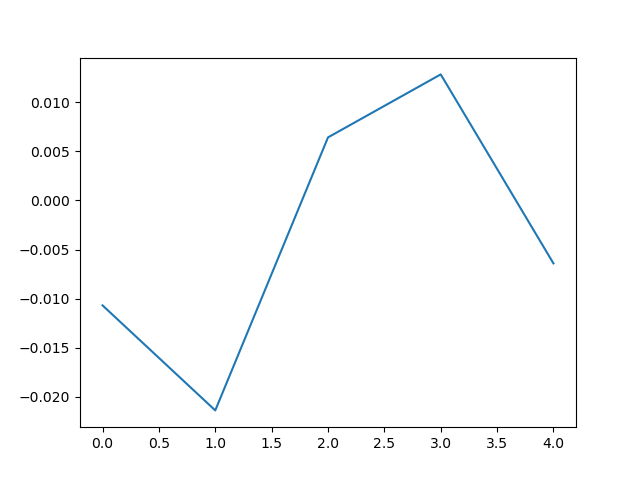

In [70]:
startPlot = 10000
plt.show(imageCompare(startPlot))

### Saving the model

In [8]:
torch.save(model.state_dict(), 'savedModel')
!ls -lh

total 812K
-rwxr--r-- 1 jettinger35 jettinger35   35 Jan  7 17:09 README.md
drwxr-xr-x 1 jettinger35 jettinger35 4.0K Jan 11 20:57 __pycache__
-rwxr--r-- 1 jettinger35 jettinger35  85K Jan 11 21:18 eegCompress.ipynb
-rwxr--r-- 1 jettinger35 jettinger35 2.7K Jan 11 20:54 eegCompressModels.py
-rw-r--r-- 1 jettinger35 jettinger35 712K Jan 11 21:23 savedModel


### Misc